In [7]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
import os
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.reset()
# Fashion - MNIST - https://github.com/zalandoresearch/fashion-mnist
mnist = keras.datasets.mnist
fashion_mnist = keras.datasets.fashion_mnist
cifar10 = keras.datasets.cifar10
#(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
#(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
#train_images = train_images.reshape((60000,  28, 28,1))
#test_images = test_images.reshape((10000,28,28,1))
train_images = train_images.reshape((50000,32,32,3))
test_images = test_images.reshape((10000,32,32,3))


# # import scipy.ndimage as ndi
# # train_images_z = ndi.zoom(train_images, (1, 512/28.0, 512/28.0, 1), order=2)

# # normalize inputs from 0-255 to 0.0-1.0
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images_norm = train_images / 255.0
test_images_norm = test_images / 255.0

# for tn in train_images_norm:
#     print(tn.shape)

# train_images=np.pad(train_images, ((0,0), (114,114), (114, 114)), 'constant')/255.0
# test_images=np.pad(test_images, ((0,0), (114,114), (114, 114)), 'constant')/255.0
# train_images_norm = train_images.reshape((60000,  256, 256,1))
# test_images_norm = test_images.reshape((10000,256,256,1))


#pad with zeros now
#paddings = tf.constant([ [0,0], [114,114], [114,114], [0,0]             ]     )
#train_images_norm = tf.pad(train_images_norm, paddings, "CONSTANT")



def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst


train_images_norm = grayscale(train_images_norm)
test_images_norm = grayscale(test_images_norm)


In [8]:
train_images_norm.shape

(50000, 32, 32, 1)

In [294]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Activation
from keras.layers import Dropout, UpSampling2D, ZeroPadding2D
from keras.layers import Flatten, Cropping1D, Cropping2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D 
from keras.engine.topology import Layer
from keras.layers import Lambda, Input
import tensorflow as tf



class NHadamard(Layer):

    def __init__(self, **kwargs):
        #self.output_dim = output_dim
        #super(MyLayer, self).__init__(**kwargs)
        super(NHadamard, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      #shape=(input_shape[1], self.output_dim),
                                      shape=(1,) + input_shape[1:],
                                      initializer='uniform',                                      
                                      trainable=True)
        super(NHadamard, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        #print(x.shape, self.kernel.shape)
        linpart =  x * tf.exp(2.0*np.pi*1j*tf.keras.backend.cast(self.kernel, dtype='complex64')           )
        xsq = tf.math.abs(x)**2
        Ifull = 2
        return linpart*tf.exp(2.0*np.pi*1j*tf.keras.backend.cast(xsq/Ifull, dtype='complex64'))

    def compute_output_shape(self, input_shape):
        #print(input_shape)
        return input_shape







class Hadamard(Layer):

    def __init__(self, **kwargs):
        #self.output_dim = output_dim
        #super(MyLayer, self).__init__(**kwargs)
        super(Hadamard, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      #shape=(input_shape[1], self.output_dim),
                                      shape=(1,) + input_shape[1:],
                                      initializer='uniform',                                      
                                      trainable=True)
        super(Hadamard, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        #print(x.shape, self.kernel.shape)
        return x * tf.exp(2.0*np.pi*1j*tf.keras.backend.cast(self.kernel, dtype='complex64')           )

    def compute_output_shape(self, input_shape):
        #print(input_shape)
        return input_shape


def propagate(x):
    N = 266
    d = 50 # plate spacing
    lam = 1    # wavelength 
    P = 0.5  # pitch of metasurface
    df = 1.0/(N*P)
    k = np.pi*2.0/lam
    

    def phase(i,j):
        i -= N//2
        j -= N//2
        return ((i*df)*(i*df)+(j*df)*(j*df))
    ph  = np.fromfunction(phase,shape=(N,N),dtype=np.float32)
#     H = np.expand_dims(np.fft.fftshift(np.exp(1.0j*k*d)*np.exp(-1.0j*lam*np.pi*d*ph)), axis=2)
    H = np.fft.fftshift(np.exp(1.0j*k*d)*np.exp(-1.0j*lam*np.pi*d*ph))
    
    x = tf.squeeze(x, axis=3)
    x2 = (tf.keras.backend.cast(x, dtype='complex64'))
    Fx = tf.fft2d(x2)*H
    
    out = tf.ifft2d(Fx)
    return tf.expand_dims(out, axis=3)

def oeconvert(x):
    return np.abs(x)**2

# photodetector pooling layer and o/E conversion
def pdpooler(x):
    x2 = (tf.math.abs(x)**2)
    N = 256
    boxes=[[ 51, 102,  51, 102], #0
    [103, 154,  51, 102],  #1
    [155, 206,  51, 102],   #2
    [ 24,  75, 103, 154],   #3
    [ 76, 127, 103, 154],   #4
    [128, 179, 103, 154],   #5
    [180, 231, 103, 154],   #6
    [ 51, 102, 155, 206],    #7
    [103, 154, 155, 206],   #8
    [155, 206, 155, 206]]   #9
 
        
#     boxes=[[120, 170, 120, 170], #0
#     [120, 170, 240, 290],  #1
#     [120, 170, 360, 410],   #2
#     [220, 270, 120, 170],   #3
#     [220, 270, 200, 250],   #4
#     [220, 270, 280, 330],   #5
#     [220, 270, 360, 410],   #6
#     [320, 370, 120, 170],    #7
#     [320, 370, 240, 290],   #8
#     [320, 370, 360, 410]]   #9
    
    
    #region = tf.math.reduce_max(x[:,3:5,3:5,:], axis=[1,2])
    region = tf.stack([ 0.2*tf.squeeze(tf.math.reduce_sum(x2[:, b[0]:b[1], b[2]:b[3],:], axis=[1,2]), axis=1)  for b in boxes])
    #region = tf.stack([ 0.001  for b in boxes], axis=1)
    #reg = tf.stack( [ np.amax(x2[:, 3:5, 3:5,:], axis=[1,2])  for b in boxes], axis=1)
    
    return tf.transpose(region)

def satabs(x):
    #print(x.shape, self.kernel.shape)
    S = 0.1
    #fac = 1.0/(1.0 - S)
    x = tf.keras.backend.cast(x, dtype='complex64')
    il = tf.math.abs(x*x)
    iout = 0.5*(tf.math.abs(il - S) + il - S + 0.0000001    )
    ampo = tf.math.sqrt(iout)
    angpart = tf.exp(1j*tf.keras.backend.cast( tf.math.angle(x), dtype='complex64')               )
    xo = angpart*tf.keras.backend.cast(ampo, dtype='complex64')
    return xo


# a function that applies a random absorption matrix
def randabs(x):
    Kappa = 0.7
    x = tf.keras.backend.cast(x, dtype='complex64')
    abr = tf.keras.backend.cast(tf.random_uniform(shape=[256,256,1], minval=Kappa, maxval=1.0), dtype='complex64')
    return x*abr

In [42]:
iput = Input(shape=(32,32,1))
upsamp = UpSampling2D(size=2)(iput)
padded = ZeroPadding2D(padding=96)(upsamp)
# #padded2 = ZeroPadding2D(padding=50)(padded)
# #cast_iput = tf.keras.backend.cast(iput,  dtype='complex64') 

prop1 = Lambda(propagate)(padded)
hada1=Hadamard()(prop1)
#nl1 = Lambda(satabs)(hada1)
prop2 = Lambda(propagate)(hada1)
hada2=Hadamard()(prop2)
#nl2 = Lambda(satabs)(hada2)
prop3 = Lambda(propagate)(hada2)
# hada3=NHadamard()(prop3)
# prop4 = Lambda(propagate)(hada3)
# hada4=NHadamard()(prop4)
# prop5 = Lambda(propagate)(hada4)
# hada5=NHadamard()(prop5)
# prop6 = Lambda(propagate)(hada5)

# pdo = Lambda(oeconvert)(prop3)
# mpool = AveragePooling2D(strides=(32,32))(pdo)
# fc = Flatten()(mpool)
# oput = Dense(10, activation='softmax')(fc)
pdo = Lambda(pdpooler)(prop3)
outp = Activation('softmax')(pdo)


model_f = Model(inputs=iput, outputs=outp)

model_f.summary()

model_f.compile(optimizer='nadam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
hstry3 = model_f.fit(train_images_norm, train_labels, epochs=60, batch_size=128, shuffle=True,
           validation_data=(test_images_norm, test_labels))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 64, 64, 1)         0         
_________________________________________________________________
zero_padding2d_5 (ZeroPaddin (None, 256, 256, 1)       0         
_________________________________________________________________
lambda_29 (Lambda)           (None, 256, 256, 1)       0         
_________________________________________________________________
hadamard_2 (Hadamard)        (None, 256, 256, 1)       65536     
_________________________________________________________________
lambda_30 (Lambda)           (None, 256, 256, 1)       0         
_________________________________________________________________
hadamard_3 (Hadamard)        (None, 256, 256, 1)       65536     
__________

50000/50000 [==============================] - 12s 243us/step - loss: 1.7289 - acc: 0.4167 - val_loss: 1.7827 - val_acc: 0.3891
Epoch 48/60
50000/50000 [==============================] - 12s 245us/step - loss: 1.7273 - acc: 0.4189 - val_loss: 1.7609 - val_acc: 0.3982
Epoch 49/60
50000/50000 [==============================] - 12s 245us/step - loss: 1.7257 - acc: 0.4206 - val_loss: 1.7638 - val_acc: 0.4023
Epoch 50/60
50000/50000 [==============================] - 12s 244us/step - loss: 1.7251 - acc: 0.4191 - val_loss: 1.7589 - val_acc: 0.4022
Epoch 51/60
50000/50000 [==============================] - 12s 245us/step - loss: 1.7245 - acc: 0.4199 - val_loss: 1.7720 - val_acc: 0.3900
Epoch 52/60
50000/50000 [==============================] - 12s 244us/step - loss: 1.7224 - acc: 0.4205 - val_loss: 1.7600 - val_acc: 0.3996
Epoch 53/60
50000/50000 [==============================] - 12s 246us/step - loss: 1.7215 - acc: 0.4214 - val_loss: 1.7640 - val_acc: 0.3992
Epoch 54/60
50000/50000 [=======

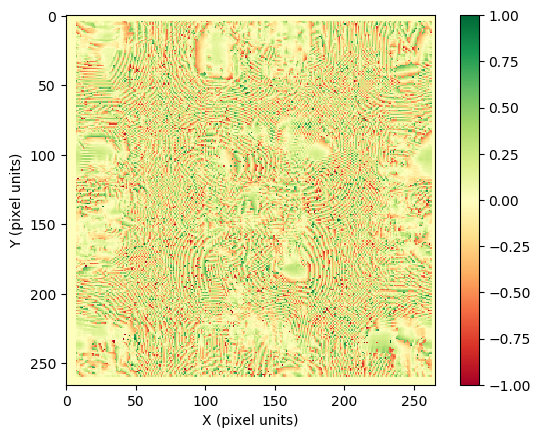

In [289]:
plt.imshow(np.squeeze(wshft), vmin=-1, vmax=1, cmap='RdYlGn')
plt.colorbar()
plt.xlabel('X (pixel units)')
plt.ylabel('Y (pixel units)')
plt.show()
#np.squeeze(wts[0])

In [295]:

#correlated noise study
manhatsh= 5  #this is the manhattan distance betwnne shifted center and ideal center
oshift = 96 + manhatsh

# uncorrelated noise study
#create a new model here and just copy the weights of te earlier network. 
iput = Input(shape=(32,32,1))
upsamp = UpSampling2D(size=2)(iput)
padded = ZeroPadding2D(padding=oshift)(upsamp)
# #padded2 = ZeroPadding2D(padding=50)(padded)
# #cast_iput = tf.keras.backend.cast(iput,  dtype='complex64') 

prop1 = Lambda(propagate)(padded)
hada1=Hadamard()(prop1)
prop2 = Lambda(propagate)(hada1)
hada2=Hadamard()(prop2)
prop3 = Lambda(propagate)(hada2)
prop3cr = Cropping2D(cropping= ( (manhatsh, manhatsh), (manhatsh, manhatsh)         )       )(prop3)
pdo = Lambda(pdpooler)(prop3cr)
outp = Activation('softmax')(pdo)


model_nw = Model(inputs=iput, outputs=outp)

model_nw.summary()

model_nw.compile(optimizer='nadam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

def phase_padder(x, padw, mhatdist):
    xp = np.pad(x, pad_width=(  (0,0), (padw, padw), (padw, padw), (0,0)), mode='constant', constant_values=0)
    xshift = np.random.randint(-mhatdist, mhatdist +1)
    ys = padw - np.abs(xshift)
    yshift = np.random.randint(-ys, ys +1)
    xpxs = np.roll(xp, shift=xshift, axis=1)
    xpys = np.roll(xpxs, shift=yshift, axis=2)
    print(xshift, yshift)
    return xpys


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 32, 32, 1)         0         
_________________________________________________________________
up_sampling2d_25 (UpSampling (None, 64, 64, 1)         0         
_________________________________________________________________
zero_padding2d_25 (ZeroPaddi (None, 266, 266, 1)       0         
_________________________________________________________________
lambda_128 (Lambda)          (None, 266, 266, 1)       0         
_________________________________________________________________
hadamard_37 (Hadamard)       (None, 266, 266, 1)       70756     
_________________________________________________________________
lambda_129 (Lambda)          (None, 266, 266, 1)       0         
_________________________________________________________________
hadamard_38 (Hadamard)       (None, 266, 266, 1)       70756     
__________

In [204]:
# uncorrelated noise study
#create a new model here and just copy the weights of te earlier network. 
iput = Input(shape=(32,32,1))
upsamp = UpSampling2D(size=2)(iput)
padded = ZeroPadding2D(padding=96)(upsamp)
# #padded2 = ZeroPadding2D(padding=50)(padded)
# #cast_iput = tf.keras.backend.cast(iput,  dtype='complex64') 

prop1 = Lambda(propagate)(padded)
hada1=Hadamard()(prop1)
hada1_abs = Lambda(randabs)(hada1)
prop2 = Lambda(propagate)(hada1_abs)
hada2=Hadamard()(prop2)
hada2_abs = Lambda(randabs)(hada2)
prop3 = Lambda(propagate)(hada2_abs)
pdo = Lambda(pdpooler)(prop3)
outp = Activation('softmax')(pdo)


model_nw = Model(inputs=iput, outputs=outp)

model_nw.summary()

model_nw.compile(optimizer='nadam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])











# #get weights of the trained network
# wts = model_f.get_weights()
# model_nw.set_weights(wts)

# preds_orig = np.argmax(model_f.predict(test_images_norm), axis=1)
# test_acc_orig = np.asarray(np.where(np.squeeze(test_labels) == preds_orig)).shape[1]
# preds_lossy = np.argmax(model_nw.predict(test_images_norm), axis=1)
# test_acc_lossy = np.asarray(np.where(np.squeeze(test_labels) == preds_lossy)).shape[1]
# def return_levelled(x, levels):
#     bins = numpy.linspace(0, 1, levels+1)
#     bins2 = numpy.linspace(0, 1, levels)
#     digitized = numpy.digitize(x, bins)
  
#     return np.asarray([bins2[x -1] for x in digitized])


# # print(test_acc_orig, test_acc_lossy)
# wts = model_f.get_weights()
# preds_orig = np.argmax(model_f.predict(test_images_norm), axis=1)
# test_acc_orig = np.asarray(np.where(np.squeeze(test_labels) == preds_orig)).shape[1]
# wts_normed = [wt%1 for wt in wts]
# vals = np.ones((10,10))
# for idx in range(8):
#     for jdx in range(10):
#         #wts2 = [wt + np.random.normal(0,0.01 + 0.01*jdx, wt.shape) for wt in wts_normed]
#         wts2 =   [ return_levelled(wt, 40 - 4*(idx)) for wt in wts_normed]   #[wt + np.random.normal(0, 1.0/(8*(idx + 1)), wt.shape) for wt in wts_normed]
#         model_nw.set_weights(wts2)
#         preds_lossy = np.argmax(model_nw.predict(test_images_norm), axis=1)
#         test_acc_lossy = np.asarray(np.where(np.squeeze(test_labels) == preds_lossy)).shape[1]

#         vals[idx,jdx] = test_acc_lossy
#         print(idx, jdx, test_acc_lossy)
#         #model_f.set_weights(wts)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 32, 32, 1)         0         
_________________________________________________________________
up_sampling2d_22 (UpSampling (None, 64, 64, 1)         0         
_________________________________________________________________
zero_padding2d_22 (ZeroPaddi (None, 256, 256, 1)       0         
_________________________________________________________________
lambda_117 (Lambda)          (None, 256, 256, 1)       0         
_________________________________________________________________
hadamard_33 (Hadamard)       (None, 256, 256, 1)       65536     
_________________________________________________________________
lambda_118 (Lambda)          (None, 256, 256, 1)       0         
_________________________________________________________________
lambda_119 (Lambda)          (None, 256, 256, 1)       0         
__________

In [177]:


vals/10000

array([[3.586e-01, 3.613e-01, 3.633e-01, 3.620e-01, 3.598e-01, 3.611e-01,
        3.615e-01, 3.614e-01, 3.642e-01, 3.622e-01],
       [3.551e-01, 3.562e-01, 3.550e-01, 3.589e-01, 3.576e-01, 3.557e-01,
        3.554e-01, 3.526e-01, 3.592e-01, 3.561e-01],
       [3.437e-01, 3.443e-01, 3.472e-01, 3.438e-01, 3.451e-01, 3.437e-01,
        3.445e-01, 3.440e-01, 3.445e-01, 3.431e-01],
       [3.442e-01, 3.418e-01, 3.468e-01, 3.408e-01, 3.444e-01, 3.426e-01,
        3.457e-01, 3.407e-01, 3.421e-01, 3.438e-01],
       [3.322e-01, 3.295e-01, 3.268e-01, 3.308e-01, 3.323e-01, 3.301e-01,
        3.345e-01, 3.333e-01, 3.351e-01, 3.350e-01],
       [3.090e-01, 3.090e-01, 3.129e-01, 3.129e-01, 3.097e-01, 3.139e-01,
        3.085e-01, 3.100e-01, 3.106e-01, 3.057e-01],
       [2.735e-01, 2.729e-01, 2.713e-01, 2.726e-01, 2.733e-01, 2.715e-01,
        2.722e-01, 2.734e-01, 2.714e-01, 2.743e-01],
       [2.351e-01, 2.361e-01, 2.367e-01, 2.347e-01, 2.353e-01, 2.347e-01,
        2.345e-01, 2.347e-01, 2.341e-

In [ ]:
# vals = np.zeros((10,10))

for idx in range(10):
    wts = model_f.get_weights()
    preds = np.argmax(model_f.predict(test_images_norm), axis=1)
    test_acc = len(np.squeeze(np.where(preds == test_labels)))/10000.0
    wts_normed = [wt%1 for wt in wts]
    
    for jdx in range(10):
        wts2 = [wt + np.random.normal(0,0.01 + 0.01*jdx, wt.shape) for wt in wts_normed]
        model_f.set_weights(wts2)
        preds = np.argmax(model_f.predict(test_images_norm), axis=1)
        test_acc = len(np.squeeze(np.where(preds == test_labels)))/10000.0
        vals[idx,jdx] = test_acc
        print(idx, jdx, test_acc)
        model_f.set_weights(wts)

In [ ]:
wts = model_f.get_weights()
preds = np.argmax(model_f.predict(test_images_norm), axis=1)
test_acc = len(np.squeeze(np.where(preds == test_labels)))/10000.0
wts_normed = [wt%1 for wt in wts]
wts2 = [np.around(wt, decimals=1) for wt in wts_normed]
model_f.set_weights(wts2)
preds = np.argmax(model_f.predict(test_images_norm), axis=1)
test_acc = len(np.squeeze(np.where(preds == test_labels)))/10000.0
vals[idx,jdx] = test_acc
print(idx, jdx, test_acc)
model_f.set_weights(wts)


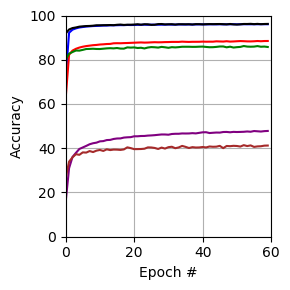

In [14]:
fig, ax = plt.subplots(figsize=(3,3))
plt.plot(100*np.asarray(hstry.history['acc']), 'b',label='F-MNIST Tr. Acc.')
plt.plot(100*np.asarray(hstry.history['val_acc']), 'k',label='F-MNIST Te. Acc.')
plt.plot(100*np.asarray(hstry2.history['acc']), 'r',label='MNIST Tr. Acc.')
plt.plot(100*np.asarray(hstry2.history['val_acc']), 'g',label='MNIST Te. Acc.')
plt.plot(100*np.asarray(hstry3.history['acc']), 'purple',label='CiFAR10 Tr. Acc.')
plt.plot(100*np.asarray(hstry3.history['val_acc']), 'brown',label='CiFAR10 Te. Acc.')
plt.ylim([0,100])
plt.xlim([0,60])
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
ax.grid(True)
#plt.legend()
plt.tight_layout()
plt.savefig('opt_dense.pdf', dpi=1600, pad_inches=0)
plt.show()

In [5]:
# model_prop1 = Model(inputs=iput, outputs=prop1)
# model_prop2 = Model(inputs=iput, outputs=prop2)
# model_prop = Model(inputs=iput, outputs=prop3)
# model_pd = Model(inputs=iput, outputs=pdo)
# pdsig = model_pd.predict(test_images_norm)
# pdinp = np.abs(model_prop.predict(test_images_norm))**2
# prop1d = np.abs(model_prop1.predict(test_images_norm))
# prop2d = np.abs(model_prop2.predict(test_images_norm))
preds = np.argmax(model_f.predict(test_images_norm), axis=1)

In [69]:

import matplotlib.patches as patches
fig, ax = plt.subplots(1,4,figsize=(8,3))
idx = np.random.randint(10000)
#plt.subplot(121)
ax[0].imshow(np.squeeze(test_images_norm[idx]), cmap='Greys_r', vmin=0, vmax=1)
ax[0].set_xticks(ticks=[])
ax[0].set_yticks(ticks=[])
ax[1].imshow(np.squeeze(np.squeeze(prop1d[idx])), cmap='Greys_r', vmin=0, vmax=1)
ax[1].set_xticks(ticks=[])
ax[1].set_yticks(ticks=[])
ax[2].imshow(np.squeeze(np.squeeze(prop2d[idx])), cmap='Greys_r', vmin=0, vmax=1)
ax[2].set_xticks(ticks=[])
ax[2].set_yticks(ticks=[])




#plt.subplot(122)
#ax[1].imshow(np.squeeze(test_images_norm[idx]), cmap='Greys_r', vmin=0, vmax=1)
plt.imshow(np.transpose(np.squeeze(pdinp[idx])), vmin=0, vmax=5, cmap='Greys_r')
#ax[1].imshow(np.squeeze(test_images_norm[idx]), cmap='Greys_r', vmin=-5, vmax=5)
rect1 = patches.Rectangle((128 - 51,103),51,51,linewidth=2,edgecolor='r',facecolor='none')
ax[3].add_patch(rect1)
rect2 = patches.Rectangle((128 - 102,103),51,51,linewidth=2,edgecolor='r',facecolor='none')
ax[3].add_patch(rect2)
rect3 = patches.Rectangle((128 ,103),51,51,linewidth=2,edgecolor='r',facecolor='none')
ax[3].add_patch(rect3)
rect4 = patches.Rectangle((128+ 51, 103),51,51,linewidth=2,edgecolor='r',facecolor='none')
ax[3].add_patch(rect4)
rect5 = patches.Rectangle((128 - 51+25,128+ 26),51,51,linewidth=2,edgecolor='r',facecolor='none')
ax[3].add_patch(rect5)
rect6 = patches.Rectangle((128 - 102+25,128 + 26),51,51,linewidth=2,edgecolor='r',facecolor='none')
ax[3].add_patch(rect6)
rect7 = patches.Rectangle((128+25 ,128 + 26),51,51,linewidth=2,edgecolor='r',facecolor='none')
ax[3].add_patch(rect7)
rect8 = patches.Rectangle((128 - 51+25,128- 51-25),51,51,linewidth=2,edgecolor='r',facecolor='none')
ax[3].add_patch(rect8)
rect9 = patches.Rectangle((128 - 102+25,128 - 51-25),51,51,linewidth=2,edgecolor='r',facecolor='none')
ax[3].add_patch(rect9)
rect10 = patches.Rectangle((128+25 ,128 - 51-25),51,51,linewidth=2,edgecolor='r',facecolor='none')
ax[3].add_patch(rect10)
ax[3].set_xticks(ticks=[])
ax[3].set_yticks(ticks=[])
plt.tight_layout()
#plt.colorbar()
plt.show()
print(preds[idx], class_names[preds[idx]], test_labels[idx])
print(pdsig[idx])

NameError: name 'prop1d' is not defined

In [ ]:
plt.imshow( np.squeeze(  np.abs(pdinp[idx])))
plt.show()

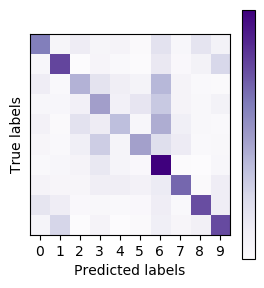

In [6]:
import sklearn.metrics as met
fig, ax = plt.subplots(figsize=(3,3))
cm = met.confusion_matrix(test_labels, preds, normalize='all')
i=ax.imshow(cm, cmap='Purples')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.yticks( ticks=[] ) #[0,1,2,3,4,5,6,7,8,9]  )
plt.xticks( ticks=[0,1,2,3,4,5,6,7,8,9]  )
#plt.ylim([-0.5,9.5])
cbar = fig.colorbar(i)
cbar.set_ticks([])
plt.tight_layout()
plt.show()

In [ ]:
def propagate(x):
    N = 28
    d = 120 # plate spacing
    lam = 1    # wavelength 
    P = 0.5  # pitch of metasurface
    df = 1.0/(N*P)
    k = np.pi*2.0/lam
    print("here")

    def phase(i,j):
        i -= N//2
        j -= N//2
        return ((i*df)*(i*df)+(j*df)*(j*df))
    ph  = np.fromfunction(phase,shape=(N,N),dtype=np.float32)
#     H = np.expand_dims(np.fft.fftshift(np.exp(1.0j*k*d)*np.exp(-1.0j*lam*np.pi*d*ph)), axis=2)
    H = np.fft.fftshift(np.exp(1.0j*k*d)*np.exp(-1.0j*lam*np.pi*d*ph))
    
    
    x2 = tf.squeeze(tf.keras.backend.cast(x, dtype='complex64'))
    Fx = tf.fft2d(x2)*H
    
    out = tf.ifft2d(Fx)
    return out

def propagate_np(x):
    N = 28
    d = 120 # plate spacing
    lam = 1    # wavelength 
    P = 0.5  # pitch of metasurface
    df = 1.0/(N*P)
    k = np.pi*2.0/lam
    def phase(i,j):
        i -= N//2
        j -= N//2
        return ((i*df)*(i*df)+(j*df)*(j*df))
    ph  = np.fromfunction(phase,shape=(N,N),dtype=np.float32)
    H = np.fft.fftshift(np.exp(1.0j*k*d)*np.exp(-1.0j*lam*np.pi*d*ph)) 
    print(H.shape)
    Fx = H*(np.fft.fft2(np.squeeze(x)))
    return np.fft.ifft2(Fx)





In [ ]:
one = propagate(train_images_norm[:27])
two = propagate_np(train_images_norm[:27])


In [ ]:
with tf.Session() as sess:
    onep = one.eval()
onep


In [ ]:
two

In [ ]:
plt.figure(figsize=(3,3))
plt.imshow(np.abs(np.squeeze(onep[10])))
plt.imshow(np.squeeze(np.abs(two[10])))
plt.show()

In [ ]:
two.shape

In [ ]:
hg = np.array([[1,2], [3,4]])

In [ ]:
hg2 = np.expand_dims(hg, axis=2)

In [ ]:
hg2

In [ ]:
-1.0123%1

In [ ]:
tf.squeeze(train_images_norm[:21])

In [ ]:
wts[0]%1

In [ ]:
np.zeros((10,10))

In [ ]:
np.round(np.round(0.27852, 2)*2.0)/2.0

In [ ]:
np.round(0.246789, decimals=4)